In [ ]:
from tqdm import tqdm 
import os 

import numpy as np 
import pandas as pd

import scipy.sparse  as sp 

from sklearn.model_selection import train_test_split 

import torch 
from torch import nn, optim 
from torch.utils.data import Dataset, DataLoader 

모델 하이퍼파라미터



layer : 3층, batch size : 512

In [ ]:
class args:
    seed = 42
    num_layers = 3
    batch_size= 512
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    SAVE_PATH = 'Parameters'

In [ ]:
d_set = pd.read_csv('ratings.dat', sep='::', names=['user_id','business_id','stars','ts'], encoding='latin-1',header=None)
d_set = d_set.drop(columns=['ts'])

<ipython-input-4-e0068a5e4b0c>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  d_set = pd.read_csv('ratings.dat', sep='::', names=['user_id','business_id','stars','ts'], encoding='latin-1',header=None)


In [ ]:
d_train, d_test = train_test_split(d_set, train_size=0.6, random_state=args.seed)
d_valid, d_test = train_test_split(d_test, train_size=0.5, random_state=args.seed)

user id와 item id 범주형으로 변경

In [ ]:
d_train = d_train.astype({'user_id':'category', 'business_id':'category'})
d_valid = d_valid.astype({'user_id':'category', 'business_id':'category'})
d_test = d_test.astype({'user_id':'category', 'business_id':'category'})

In [ ]:
u_cat = d_train.user_id.cat.categories
b_cat = d_train.business_id.cat.categories

set_categories 통해 train data에 있는 카테고리 valid data에 생성

In [ ]:
d_valid.user_id = d_valid.user_id.cat.set_categories(u_cat)
d_valid.business_id = d_valid.business_id.cat.set_categories(b_cat)

d_test.user_id = d_test.user_id.cat.set_categories(u_cat)
d_test.business_id = d_test.business_id.cat.set_categories(b_cat)

codes 통해 user id와 item id 숫자 변환

In [ ]:
d_train.user_id = d_train.user_id.cat.codes
d_train.business_id = d_train.business_id.cat.codes 

d_valid.user_id = d_valid.user_id.cat.codes
d_valid.business_id = d_valid.business_id.cat.codes 

d_test.user_id = d_test.user_id.cat.codes
d_test.business_id = d_test.business_id.cat.codes 

In [ ]:
d_train = d_train.dropna()
d_valid = d_valid.dropna()
d_test = d_test.dropna()

d_train.reset_index(drop=True, inplace=True)
d_valid.reset_index(drop=True, inplace=True)
d_test.reset_index(drop=True, inplace=True)

In [ ]:
d_train = d_train.astype({'user_id': int, 'business_id': int})
d_valid = d_valid.astype({'user_id': int, 'business_id': int})
d_test = d_test.astype({'user_id': int, 'business_id': int})

In [ ]:
args.num_users = d_train.user_id.max() + 1
args.num_items = d_train.business_id.max() + 1
args.latent_dim = 64
args.num_epochs = 50

torch.nn.module : PyTorch의 모든 Neural Network의 Base Class

nn.Module을 상속받아서 기본적인 기능들을 사용할 수 있게 만들어줌

Massage Passing 단계 (Message Construction 및 Message Aggregation)


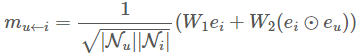


코드를 실행시킬 때에는 행렬 형태로 변환하고 계산하기 때문에 계산의 효율성 문제로 행렬로 변환
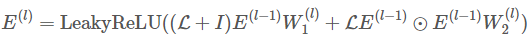


In [ ]:
class GNNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GNNLayer, self).__init__()
        self.in_feats = in_feats
        self.out_feats = out_feats 

        self.W1 = nn.Linear(in_feats, out_feats)
        self.W2 = nn.Linear(in_feats, out_feats)

    def forward(self, L, SelfLoop, feats):
        # (L+I)EW_1
        sf_L = L + SelfLoop
        L = L.cuda()  # .cuda() -> GPU 활용
        sf_L = sf_L.cuda() 
        sf_E = torch.sparse.mm(sf_L, feats)  # sparse 행렬 coo or csr 형식으로 메모리 절약, mm -> 행렬곱(matmul과 다른점은  broadcast 기능을 제공해주기 때문에 도리어 debug point가 될 수 있다.)
        left_part = self.W1(sf_E) # left part

        # EL odot EW_2, odot indicates element-wise product 
        LE = torch.sparse.mm(L, feats)
        E = torch.mul(LE, feats)
        right_part = self.W2(E)

        return left_part + right_part 

nn.Embedding()을 통해 user와 item embedding 생성(룩업테이블)

LaplacianMatrix

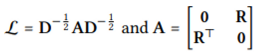

Upper Matrix는 [0, R]로 표현된 행렬의 윗 부분을 만들기 위함이고, Lower Matrix는 그 아래의 [R, 0]행렬 부분을 만들기 위함. 

그 후 vstack 함수를 사용해 합친 후 Diagonal Matrix와 Adjacency Matrix를 곱해 Laplacian Matrix를 생성.


In [1]:
class NGCF(nn.Module):
    def __init__(self, args, matrix):
        super(NGCF, self).__init__()
        self.num_users = args.num_users 
        self.num_items = args.num_items 
        self.latent_dim = args.latent_dim 
        self.device = args.device

        self.user_emb = nn.Embedding(self.num_users, self.latent_dim)
        self.item_emb = nn.Embedding(self.num_items, self.latent_dim)

        self.num_layers = args.num_layers
        self.L = self.LaplacianMatrix(matrix)
        self.I = self.SelfLoop(self.num_users + self.num_items)

        self.leakyrelu = nn.LeakyReLU()
        self.GNNLayers = nn.ModuleList()

        for i in range(self.num_layers-1):
            self.GNNLayers.append(GNNLayer(self.latent_dim, self.latent_dim))

        self.fc_layer = nn.Sequential(
            nn.Linear(self.latent_dim * self.num_layers * 2, 64), 
            nn.ReLU(), 
            nn.Linear(64, 32), 
            nn.ReLU(), 
            nn.Linear(32, 1)
        )

    def SelfLoop(self, num):
        i = torch.LongTensor([[k for k in range(0, num)], [j for j in range(0, num)]]) # torch.LongTensor 정수형
        val = torch.FloatTensor([1]*num)
        return torch.sparse.FloatTensor(i, val)

    def LaplacianMatrix(self, ratings):
        iids = ratings['business_id'] + self.num_users 
        matrix = sp.coo_matrix((ratings['stars'], (ratings['user_id'], ratings['business_id'])))
        
        upper_matrix = sp.coo_matrix((ratings['stars'], (ratings['user_id'], iids)))
        lower_matrix = matrix.transpose()
        lower_matrix.resize((self.num_items, self.num_users + self.num_items))

        A = sp.vstack([upper_matrix, lower_matrix])
        row_sum = (A > 0).sum(axis=1)
        # row_sum = np.array(row_sum).flatten()
        diag = list(np.array(row_sum.flatten())[0])
        D = np.power(diag, -0.5)
        D = sp.diags(D)
        L = D * A * D
        L = sp.coo_matrix(L)
        row = L.row 
        col = L.col
        idx = np.stack([row, col])
        idx = torch.LongTensor(idx)
        data = torch.FloatTensor(L.data)
        SparseL = torch.sparse.FloatTensor(idx, data)
        return SparseL 

    def FeatureMatrix(self):
        uids = torch.LongTensor([i for i in range(self.num_users)]).to(self.device)
        iids = torch.LongTensor([i for i in range(self.num_items)]).to(self.device)
        user_emb = self.user_emb(uids)
        item_emb = self.item_emb(iids)
        features = torch.cat([user_emb, item_emb], dim=0)  # torch.cat으로 텐서 user_emb과 item_emb 쌓음
        return features

    def forward(self, uids, iids):
        iids = self.num_users + iids 

        features = self.FeatureMatrix()
        final_emb = features.clone()

        for gnn in self.GNNLayers:
            features = gnn(self.L, self.I, features)
            features = self.leakyrelu(features)
            final_emb = torch.concat([final_emb, features],dim=-1)

        user_emb = final_emb[uids]
        item_emb = final_emb[iids]

        inputs = torch.concat([user_emb, item_emb], dim=-1)
        outs = self.fc_layer(inputs)
        return outs.flatten()

NameError: ignored

DataLoader

GraphDataset이라는 클래스로 user, item, rating 데이터의 길이와 인덱스를 지정해줌

In [ ]:
class GraphDataset(Dataset):
    def __init__(self, dataframe):
        super(Dataset, self).__init__()
        
        self.uid = list(dataframe['user_id'])
        self.iid = list(dataframe['business_id'])
        self.ratings = list(dataframe['stars'])
    
    def __len__(self):
        return len(self.uid)
    
    def __getitem__(self, idx):
        uid = self.uid[idx]
        iid = self.iid[idx]
        rating = self.ratings[idx]
        
        return (uid, iid, rating)

DataLoader 통해서 batch size, num_workers 지정

In [ ]:
def get_loader(args, dataset, num_workers):
    d_set = GraphDataset(dataset)
    return DataLoader(d_set, batch_size=args.batch_size, num_workers=num_workers)

In [ ]:
train_loader = get_loader(args, d_train, 4)
valid_loader = get_loader(args, d_valid, 4)
test_loader = get_loader(args, d_test, 4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
def graph_evaluate(args, model, test_loader, criterion):
    output = []
    test_loss = 0

    model.eval()
    with torch.no_grad():
        for batch in tqdm(test_loader, desc='evaluating...'):
            batch = tuple(b.to(args.device) for b in batch)
            inputs = {'uids':   batch[0], 
                      'iids':   batch[1]}
            gold_y = batch[2].float()
            
            pred_y = model(**inputs)
            output.append(pred_y)
            
            loss = criterion(pred_y, gold_y)
            loss = torch.sqrt(loss)
            test_loss += loss.item()
    test_loss /= len(test_loader)
    return test_loss, output

In [ ]:
def graph_train(args, model, train_loader, valid_loader, optimizer, criterion):
    best_loss = float('inf')
    train_losses, valid_losses = [], []
    for epoch in range(1, args.num_epochs + 1):
        train_loss = 0.0

        model.train()
        for batch in tqdm(train_loader, desc='training...'):
            batch = tuple(b.to(args.device) for b in batch)
            inputs = {'uids':   batch[0], 
                      'iids':   batch[1]}
            
            gold_y = batch[2].float()
            

            pred_y = model(**inputs)
            
            loss = criterion(pred_y, gold_y)
            loss = torch.sqrt(loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        valid_loss , outputs = graph_evaluate(args, model, valid_loader, criterion)
        valid_losses.append(valid_loss)
        

        print(f'Epoch: [{epoch}/{args.num_epochs}]')
        print(f'Train Loss: {train_loss:.4f}\tValid Loss: {valid_loss:.4f}')

        if best_loss > valid_loss:
            best_loss = valid_loss
            if not os.path.exists(args.SAVE_PATH):
                os.makedirs(args.SAVE_PATH)
            torch.save(model.state_dict(), os.path.join(args.SAVE_PATH, f'{model._get_name()}_parameters.pt'))

    return {
        'train_loss': train_losses, 
        'valid_loss': valid_losses
    }, outputs

In [ ]:
models = NGCF(args, d_train).to(args.device)

optimizer = optim.Adam(models.parameters(), lr = 1e-3)
criterion = nn.L1Loss()

In [ ]:
results = graph_train(args, models, train_loader, valid_loader, optimizer, criterion)

evaluating...: 100%|██████████| 251/251 [00:23<00:00, 10.76it/s]


Epoch: [1/50]
Train Loss: 0.7521	Valid Loss: 0.8710


evaluating...: 100%|██████████| 251/251 [00:22<00:00, 11.13it/s]


Epoch: [2/50]
Train Loss: 0.7503	Valid Loss: 0.8731


evaluating...: 100%|██████████| 251/251 [00:23<00:00, 10.74it/s]


Epoch: [3/50]
Train Loss: 0.7488	Valid Loss: 0.8761


evaluating...: 100%|██████████| 251/251 [00:23<00:00, 10.81it/s]


Epoch: [4/50]
Train Loss: 0.7476	Valid Loss: 0.8775


evaluating...: 100%|██████████| 251/251 [00:23<00:00, 10.87it/s]


Epoch: [5/50]
Train Loss: 0.7465	Valid Loss: 0.8763


evaluating...: 100%|██████████| 251/251 [00:22<00:00, 11.25it/s]


Epoch: [6/50]
Train Loss: 0.7456	Valid Loss: 0.8762


evaluating...: 100%|██████████| 251/251 [00:23<00:00, 10.90it/s]


Epoch: [7/50]
Train Loss: 0.7447	Valid Loss: 0.8775


evaluating...: 100%|██████████| 251/251 [00:23<00:00, 10.72it/s]


Epoch: [8/50]
Train Loss: 0.7437	Valid Loss: 0.8781


evaluating...: 100%|██████████| 251/251 [00:23<00:00, 10.77it/s]


Epoch: [9/50]
Train Loss: 0.7425	Valid Loss: 0.8778


evaluating...: 100%|██████████| 251/251 [00:22<00:00, 10.96it/s]


Epoch: [10/50]
Train Loss: 0.7417	Valid Loss: 0.8783


evaluating...: 100%|██████████| 251/251 [00:23<00:00, 10.88it/s]


Epoch: [11/50]
Train Loss: 0.7406	Valid Loss: 0.8812


evaluating...: 100%|██████████| 251/251 [00:23<00:00, 10.79it/s]


Epoch: [12/50]
Train Loss: 0.7392	Valid Loss: 0.8811


evaluating...: 100%|██████████| 251/251 [00:25<00:00, 10.02it/s]


Epoch: [13/50]
Train Loss: 0.7382	Valid Loss: 0.8808


evaluating...: 100%|██████████| 251/251 [00:24<00:00, 10.21it/s]


Epoch: [14/50]
Train Loss: 0.7373	Valid Loss: 0.8821


evaluating...: 100%|██████████| 251/251 [00:22<00:00, 10.95it/s]


Epoch: [15/50]
Train Loss: 0.7362	Valid Loss: 0.8816


evaluating...: 100%|██████████| 251/251 [00:22<00:00, 10.96it/s]


Epoch: [16/50]
Train Loss: 0.7351	Valid Loss: 0.8807


evaluating...: 100%|██████████| 251/251 [00:24<00:00, 10.38it/s]


Epoch: [17/50]
Train Loss: 0.7340	Valid Loss: 0.8821


evaluating...: 100%|██████████| 251/251 [00:23<00:00, 10.56it/s]


Epoch: [18/50]
Train Loss: 0.7335	Valid Loss: 0.8812


evaluating...: 100%|██████████| 251/251 [00:23<00:00, 10.64it/s]


Epoch: [19/50]
Train Loss: 0.7330	Valid Loss: 0.8810


evaluating...: 100%|██████████| 251/251 [00:23<00:00, 10.72it/s]


Epoch: [20/50]
Train Loss: 0.7324	Valid Loss: 0.8821


evaluating...: 100%|██████████| 251/251 [00:22<00:00, 11.29it/s]


Epoch: [21/50]
Train Loss: 0.7320	Valid Loss: 0.8833


evaluating...: 100%|██████████| 251/251 [00:21<00:00, 11.68it/s]


Epoch: [22/50]
Train Loss: 0.7318	Valid Loss: 0.8847


evaluating...: 100%|██████████| 251/251 [00:21<00:00, 11.56it/s]


Epoch: [23/50]
Train Loss: 0.7309	Valid Loss: 0.8832


evaluating...: 100%|██████████| 251/251 [00:21<00:00, 11.66it/s]


Epoch: [24/50]
Train Loss: 0.7294	Valid Loss: 0.8834


evaluating...: 100%|██████████| 251/251 [00:21<00:00, 11.56it/s]


Epoch: [25/50]
Train Loss: 0.7275	Valid Loss: 0.8842


evaluating...: 100%|██████████| 251/251 [00:22<00:00, 11.34it/s]


Epoch: [26/50]
Train Loss: 0.7257	Valid Loss: 0.8854


evaluating...: 100%|██████████| 251/251 [00:21<00:00, 11.50it/s]


Epoch: [27/50]
Train Loss: 0.7241	Valid Loss: 0.8860


evaluating...: 100%|██████████| 251/251 [00:22<00:00, 11.41it/s]


Epoch: [28/50]
Train Loss: 0.7228	Valid Loss: 0.8870


evaluating...: 100%|██████████| 251/251 [00:21<00:00, 11.42it/s]


Epoch: [29/50]
Train Loss: 0.7220	Valid Loss: 0.8845


evaluating...: 100%|██████████| 251/251 [00:21<00:00, 11.50it/s]


Epoch: [30/50]
Train Loss: 0.7208	Valid Loss: 0.8857


evaluating...: 100%|██████████| 251/251 [00:21<00:00, 11.44it/s]


Epoch: [31/50]
Train Loss: 0.7199	Valid Loss: 0.8857


evaluating...: 100%|██████████| 251/251 [00:21<00:00, 11.41it/s]


Epoch: [32/50]
Train Loss: 0.7194	Valid Loss: 0.8852


evaluating...: 100%|██████████| 251/251 [00:21<00:00, 11.57it/s]


Epoch: [33/50]
Train Loss: 0.7185	Valid Loss: 0.8847


training...:  18%|█▊        | 134/753 [00:14<01:07,  9.20it/s]

In [ ]:
torch.cuda.get_arch_list()

['sm_37', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86', 'sm_90']